In [ ]:
## General initialization

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
import numpy as np
seed = 42
if seed is not None:
   np.random.seed(seed)

# Read Data

In [2]:
## Reading input training Data

#configuration path Data
path_train_data = "./data/processed/train.json"

#Read Data
import numpy as np
import pandas as pd
train_data = pd.read_json(path_train_data)
print("Size of train data:{}".format(len(train_data)))

#Size of images
size_image = len(train_data.iloc[0]['band_1'])
print("size of image in band_1: {}".format(size_image))
width_image = int(np.sqrt(size_image))
print("Shape of image: {}x{}".format(width_image, width_image))

#Percentage Ships/icebergs
idx_iceberg_td = train_data["is_iceberg"] == 1
idx_ship_td = train_data["is_iceberg"] == 0
num_iceberg_in_train_data = train_data[idx_iceberg_td].shape[0]
print("In train data: percentage of iceberg: {}%".format(100 * num_iceberg_in_train_data / train_data.shape[0]))


Size of train data:1604
size of image in band_1: 5625
Shape of image: 75x75
In train data: percentage of iceberg: 46.94513715710723%


=> The training data set is quite balanced between the two classes

In [ ]:
## Reading input Test Competition Kaggle Data

#configuration path Data
path_test_data = "./data/processed/test.json"

#Read Data
import numpy as np
import pandas as pd
test_data = pd.read_json(path_test_data)
print("size of test data:{}".format(len(test_data)))


=> The test dataset of the competition is much larger than the training set. 
It may be interesting to learn by unsupervised learning from this data set


In [ ]:
# Let's have a look at the dirst datas
from IPython.display import display # Allows the use of display() for DataFrames
display(train_data.head())


In [3]:
##################################################
##  pre processing inc_angle NaN values

#Some of the incident angle from the satellite are unknown and marked as "na". 
#Replace these na with 0 and find the indices where the incident angle is >0 
#This way we can use a truncated set or the full set of training data.

# Find indexes where there is no angle
idx_inc_angle_nan_td = np.where(train_data["inc_angle"] == 'na')
idx_inc_angle_not_nan_td = np.where(train_data["inc_angle"] != 'na')
print("Number of missing value for inc angle in training: {}".format(idx_inc_angle_nan_td[0].shape[0]))



#transform in numeric the inc_angle in new column inc_angle_numeric
train_data["inc_angle_numeric"] = pd.to_numeric(train_data.inc_angle, errors='coerce')

#replace the nan value for the mean in new columns inc_angle_corrected_mean
train_data["inc_angle_corrected_mean"] = train_data["inc_angle_numeric"]
mean_angle = train_data.inc_angle_corrected_mean.mean(skipna=True)
std_angle = train_data.inc_angle_corrected_mean.std(skipna=True)
median_angle = train_data.inc_angle_corrected_mean.median(skipna=True)
train_data["inc_angle_corrected_mean"].fillna(mean_angle, inplace=True)
print("Mean value for missing value: {}, std={}, median:{}".format(mean_angle, std_angle, median_angle))

#Check Mean squared error if we had a regressor which always returns the mean
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
pred = [mean_angle]*len(idx_inc_angle_not_nan_td[0])
groundTruth = train_data['inc_angle_corrected_mean'][idx_inc_angle_not_nan_td[0]]
mse = mean_squared_error(groundTruth, pred)

meanae =  median_absolute_error(groundTruth, pred) 
#mae is more robust to outliers
medianae =  median_absolute_error(groundTruth, pred) 
print("Mean Squared error for predicting always mean value: {}".format(mse))
print("Mean absolute  error for predicting always mean value: {}".format(meanae))
print("Median absolute  error for predicting always mean value: {}".format(medianae))



#for backward compatibility
train_data['inc_angle_corrected'] = train_data['inc_angle_corrected_mean']

# Plot the histogram of inc_angle fo original and corrected with mean
import matplotlib.pyplot as plt
plt.title("histogram inc_angle corected")
train_data.inc_angle_corrected_mean.hist()
plt.show()

plt.title("histogram inc_angle original")
train_data.inc_angle_numeric.hist()
plt.show()

Number of missing value for inc angle in training: 133
Mean value for missing value: 39.26870747790618, std=3.8397444116664374, median:39.5015
Mean Squared error for predicting always mean value: 14.733614280066448
Mean absolute  error for predicting always mean value: 3.288992522093814
Median absolute  error for predicting always mean value: 3.288992522093814


=> It seems that if  we replace the Nan value by the mean, we did not make a big mistake 

# Visual data exploration

## Basic Ships and Icebergs Images

In [ ]:
#Visualization of examples of Band_1 band_2 as images

import matplotlib.pyplot as plt
num_show = 10
def plot_images(idx,num,label):
    fig = plt.figure(figsize=(50,50))
    plt.suptitle('Data with '+label, fontsize=40)
    for i in range(num_show):
        plt.subplot(num_show,2,2*i + 1)
        plt.title("band_1")
        img = np.array(train_data[idx].iloc[i]['band_1']).reshape(75,75)
        plt.imshow(img)
    
        plt.subplot(num_show,2,2*i + 2)
        plt.title("band_2")
        img = np.array(train_data[idx].iloc[i]['band_2']).reshape(75,75)
        plt.imshow(img)
    plt.show()
    
# visualization of the first 10 instances classified as iceberg
plot_images(idx_iceberg_td,10,'Iceberg')

# visualization of the first 10 instances classified as Ships
plot_images(idx_ship_td,10,'Ships')

=> It seems that the iceberg images are more blurry, and the ships images have more strong light pattern.

## Color Composites visualization

In [4]:
########################################
## Definition of utils function to create images to tensors


# Definition of pre processing function

def no_process(t):
    return t

def min_max_scaler(t, scale=1):
    tmin = t.min()
    return  scale*(t - tmin) / (t.max() - tmin)

def min_max_mean_scaler(t):
    return  (t - t.mean()) / (t.max() - t.min())



# Definition of 4 functions to create the composite channel with the band1 and band2

def create_band3_1(band1, band2):
    return band1/band2

def create_band3_2(band1, band2):
    return (band1 + band2) /2

def create_band3_3(band1, band2):
    return band1 - band2

def create_band3_4(band1, band2):
    return np.ones(band1.shape)



# Definition of function to create tensor from image data according pre processing filter

def to_tensor(data, 
              fn_process_band = no_process,
              fn_create_band_3 = create_band3_1):
    """
    Create a tensor of the data
    """
    tensor = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        if fn_create_band_3:
            band_3 = fn_create_band_3(band_1,band_2)
        
        band_1 = fn_process_band(band_1)
        band_2 = fn_process_band(band_2)
        if fn_create_band_3:
            band_3 = fn_process_band(band_3)
        
        if fn_create_band_3:
            t = np.dstack((band_1, band_2, band_3))
        else:
            t = np.dstack((band_1, band_2))
        tensor.append(t)
    return np.array(tensor)



In [ ]:
import matplotlib.pyplot as plt
def plot_stat_train_tensor(label_stat,
                     stat,
                     label_process = "None to Band - minmaxscaler to tensor",
                     fn_process_band = no_process,
                     fn_process_tensor = min_max_scaler,
                           
                     label_band3 = "HH/HV",
                     fn_create_band_3 = create_band3_1):
    tensor_data = to_tensor(train_data,
                            fn_process_band = fn_process_band,
                            fn_create_band_3 = fn_create_band_3)
    tensor_iceberg_data = to_tensor(train_data[idx_iceberg_td],
                                    fn_process_band = fn_process_band,
                                    fn_create_band_3 = fn_create_band_3)
    tensor_ship_data = to_tensor(train_data[idx_ship_td],
                                 fn_process_band = fn_process_band,
                                 fn_create_band_3 = fn_create_band_3)

    img_stat_data = stat(tensor_data, axis=0) 
    img_stat_iceberg_data = stat(tensor_iceberg_data,axis=0) 
    img_stat_ship_data = stat(tensor_ship_data,axis=0) 
    
    img_stat_data = fn_process_tensor(img_stat_data)
    img_stat_iceberg_data = fn_process_tensor(img_stat_iceberg_data)
    img_stat_ship_data = fn_process_tensor(img_stat_ship_data)
    
    
    plt.figure()
    plt.suptitle(label_stat+" images processing:"+label_process+', band3='+label_band3)

    plt.subplot(1,3,1)
    plt.title("Iceberg")
    plt.imshow(img_stat_iceberg_data)

    plt.subplot(1,3,2)
    plt.title("Ship")
    plt.imshow(img_stat_ship_data)

    plt.subplot(1,3,3)
    plt.title("Ship+Iceberg")
    plt.imshow(img_stat_data)

    plt.show()


    
#No Process, band3 = HH/HV
#tensor_data = to_tensor(train_data, fn_process_band=no_process, fn_create_band_3=create_band3_1)
#tensor_iceberg_data = to_tensor(train_data[idx_iceberg_td], fn_process_band=no_process, fn_create_band_3=create_band3_1)
#tensor_ship_data = to_tensor(train_data[idx_ship_td], fn_process_band=no_process, fn_create_band_3=create_band3_1)

plot_stat_train_tensor("Training Mean",np.mean)
plot_stat_train_tensor("Training Std",np.std)

#No Process, band3 = (HH + HV)/2
plot_stat_train_tensor("Training Mean",np.mean, 
                       label_band3="(HH + HV)/2",
                       fn_create_band_3=create_band3_2)
plot_stat_train_tensor("Training Std",np.std, 
                       label_band3="(HH + HV)/2",
                       fn_create_band_3=create_band3_2)


#No Process, band3 = HH - HV
plot_stat_train_tensor("Training Mean",np.mean, 
                       label_band3="(HH - HV)", 
                       fn_create_band_3=create_band3_3)
plot_stat_train_tensor("Training Std",np.std,
                       label_band3="(HH - HV)",
                       fn_create_band_3=create_band3_3)

#No Process, band3 = ones
plot_stat_train_tensor("Training Mean",np.mean, 
                       label_band3="ones", 
                       fn_create_band_3=create_band3_4)
plot_stat_train_tensor("Training Std",np.std, 
                       label_band3="ones",
                       fn_create_band_3=create_band3_4)



#Min Max Sacler Process, band3 = default
plot_stat_train_tensor("Training Mean",np.mean, 
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process)
plot_stat_train_tensor("Training Std",np.std, 
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process)



#Min Max Sacler Process, band3 = (HH + HV)/2
plot_stat_train_tensor("Training Mean",np.mean, label_band3="(HH + HV)/2",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_2)
plot_stat_train_tensor("Training Std",np.std, 
                       label_band3="(HH + HV)/2",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_2)



#Min Max Sacler Process, band3 = ones
plot_stat_train_tensor("Training Mean",np.mean, label_band3="ones",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_4)
plot_stat_train_tensor("Training Std",np.std, 
                       label_band3="ones",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_4)









In [ ]:

def plot_stat_test_tensor(label_stat,
                     stat,
                     label_process="None to band, min_max_scaler to tensor",
                     fn_process_band = no_process,
                     fn_process_tensor = min_max_scaler,
                     label_band3="HH/HV",
                     fn_create_band_3=create_band3_1):
    tensor_data = to_tensor(test_data, fn_process_band=fn_process_band, fn_create_band_3=fn_create_band_3)
    img_mean_data = stat(tensor_data,axis=0) 
    
    img_mean_data = fn_process_tensor(img_mean_data)
    
    plt.figure()
    plt.suptitle(label_stat+" images process:"+label_process+' band3='+label_band3)

    plt.subplot(1,1,1)
    plt.title("All")
    plt.imshow(img_mean_data)

    plt.show()

if  'test_data' not in locals():
    print("Skip this Kernel because test_data not defined")
else:
    plot_stat_test_tensor("Test Mean",np.mean)
    plot_stat_test_tensor("Test Std",np.std)


    #Min Max Sacler Process, band3 = default
    plot_stat_test_tensor("Test Mean",np.mean, 
                           label_process =  "min_max_scaler to Band - None to tensor ",
                           fn_process_band = min_max_scaler,
                           fn_process_tensor = no_process)
    plot_stat_test_tensor("Test Std",np.std, 
                           label_process =  "min_max_scaler to Band - None to tensor ",
                           fn_process_band = min_max_scaler,
                           fn_process_tensor = no_process)

    plot_stat_test_tensor("Test Mean",np.mean, label_band3="(HH + HV)/2",
                           label_process =  "min_max_scaler to Band - None to tensor ",
                           fn_process_band = min_max_scaler,
                           fn_process_tensor = no_process,
                           fn_create_band_3=create_band3_2)
    plot_stat_test_tensor("Test Std",np.std, 
                           label_band3="(HH + HV)/2",
                           label_process =  "min_max_scaler to Band - None to tensor ",
                           fn_process_band = min_max_scaler,
                           fn_process_tensor = no_process,
                           fn_create_band_3=create_band3_2)




In [ ]:
#Plot Mean images for Iceberg and Ship and For Each bands
def extract_band(data,
                 pre_process = no_process):
    tensor_band_1 = []
    tensor_band_2 = []
    
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        
        band_1 = pre_process(band_1)
        band_2 = pre_process(band_2)
        
        
        tensor_band_1.append(band_1)
        tensor_band_2.append(band_2)
        
    return (np.array(tensor_band_1),np.array(tensor_band_2))

def plot_mean_by_band(label_process="default",
                      pre_process = no_process):
    tensor_data = extract_band(train_data, pre_process=pre_process)
    tensor_iceberg_data = extract_band(train_data[idx_iceberg_td], pre_process=pre_process)
    tensor_ship_data = extract_band(train_data[idx_ship_td], pre_process=pre_process)

    img_mean_data_1, img_mean_data_2 = [np.mean(td,axis=0) for td in tensor_data]
    img_mean_iceberg_data_1, img_mean_iceberg_data_2 = [np.mean(td,axis=0) for td in tensor_iceberg_data]
    img_mean_ship_data_1, img_mean_ship_data_2 = [np.mean(td,axis=0) for td in tensor_ship_data]


    plt.figure()
    plt.suptitle("Mean images (Band_1,Band_2) process:"+label_process)

    plt.subplot(2,3,1)
    plt.title("Iceberg Band_1")
    plt.imshow(img_mean_iceberg_data_1)

    plt.subplot(2,3,2)
    plt.title("Ship Band_1")
    plt.imshow(img_mean_ship_data_1)

    plt.subplot(2,3,3)
    plt.title("Ship+Iceberg Band 1")
    plt.imshow(img_mean_data_1)


    plt.subplot(2,3,4)
    plt.title("Iceberg Band_2")
    plt.imshow(img_mean_iceberg_data_2)

    plt.subplot(2,3,5)
    plt.title("Ship Band_2")
    plt.imshow(img_mean_ship_data_2)

    plt.subplot(2,3,6)
    plt.title("Ship+Iceberg Band 2")
    plt.imshow(img_mean_data_2)

    plt.show()
    
plot_mean_by_band()
#plot_mean_by_band(label_process='Max Scaling', pre_process= lambda t : min_max_scaler(t,1))
plot_mean_by_band(label_process='Max Scaling and recenter', pre_process= lambda t : min_max_mean_scaler(t))

## Extraction highest pixel 

In [ ]:
def extract2(v):
    v_arr = np.array(v)
    return v_arr*(v_arr > (v_arr.mean() + 2*v_arr.std()))

from scipy.ndimage import gaussian_filter
from skimage.morphology import opening, closing
from skimage.morphology import erosion, dilation
from skimage.morphology import square
import matplotlib.pyplot as plt


def show_image(data, title):
    img_original = np.array(data).reshape((75,75))
    img_blured = gaussian_filter(img_original, 2)
    

    img_original_high = extract2(img_original.reshape(75*75)).reshape((75,75))
    img_blured_high = extract2(img_blured.reshape(75*75)).reshape((75,75))

    img_orig_high_opening = opening(img_original_high, square(3))
    img_blured_high_opening = opening(img_blured_high, square(3))

    img_orig_high_closing = closing(img_original_high, square(3))
    img_blured_high_closing = closing(img_blured_high, square(3))


    
    img_orig_high_erosion = erosion(img_original_high)
    img_blured_high_erosion = erosion(img_blured_high)

    img_orig_high_dilation = dilation(img_original_high)
    img_blured_high_dilation = dilation(img_blured_high)


    nRow = 6
    fig = plt.figure(figsize=(30,30))
    plt.suptitle(title, fontsize=40)
    plt.subplot(nRow,2,1)
    plt.title("Original")
    plt.imshow(img_original)
    plt.subplot(nRow,2,2)
    plt.title("Blured")
    plt.imshow(img_blured)

    plt.subplot(nRow,2,3)
    plt.title("Original: High pixel extracted")
    plt.imshow(img_original_high)
    plt.subplot(nRow,2,4)
    plt.title("Blurred: High pixel extracted")
    plt.imshow(img_blured_high)

    plt.subplot(nRow,2,5)
    plt.title("Original + opening: High pixel extracted")
    plt.imshow(img_orig_high_opening)
    plt.subplot(nRow,2,6)
    plt.title("blured + opening: High pixel extracted")
    plt.imshow(img_blured_high_opening)

    plt.subplot(nRow,2,7)
    plt.title("Original + closing: High pixel extracted")
    plt.imshow(img_orig_high_closing)
    plt.subplot(nRow,2,8)
    plt.title("blured + closing: High pixel extracted")
    plt.imshow(img_blured_high_closing)
    
    plt.subplot(nRow,2,9)
    plt.imshow(img_orig_high_erosion)
    plt.title("Original + Erosion: High pixel extracted")
    plt.subplot(nRow,2,10)
    plt.imshow(img_blured_high_erosion)
    plt.title("Blured + erosion: High pixel extracted")
    

    plt.subplot(nRow,2,11)
    plt.title("Original + dilation: High pixel extracted")
    plt.imshow(img_orig_high_dilation)
    plt.subplot(nRow,2,12)
    plt.title("Blured + Dilation: High pixel extracted")
    plt.imshow(img_blured_high_dilation)
    
icebergs_samples = train_data[train_data['is_iceberg'] == True].sample(5)
ships_samples = train_data[train_data['is_iceberg'] == False].sample(5)




for i, sample in icebergs_samples.iterrows():
    show_image(sample['band_1'], "Iceberg: Band_1 for sample " + str(i))
for i, sample in ships_samples.iterrows():
    show_image(sample['band_1'], "Ships: Band_1 for sample " + str(i))





## Shape Exploration

In [ ]:
from skimage import measure

def show_contour(data):
    img_original = np.array(data).reshape((75,75))
    img_original_high = extract2(img_original.reshape(75*75)).reshape((75,75))
    img_orig_high_dilation = dilation(img_original_high)
    img_orig_closed = closing(img_original_high)
    
    img_blured = gaussian_filter(img_original, 2)
    img_blured_high = extract2(img_blured.reshape(75*75)).reshape((75,75))
    img_blured_high_dilation = dilation(img_blured_high)
    img_blured_closed = closing(img_blured_high) 

    
    r = img_orig_closed
    #r = img_blured_high_dilation
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(r, 1.0)
    label_img = measure.label(r)
    props = measure.regionprops(label_img)
    

    # Display the image and plot all contours found
    fig, ax = plt.subplots()
    ax.imshow(r, interpolation='nearest')
    
    print('num contours: {}'.format(len(contours)))
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    return props

for i, sample in icebergs_samples.iterrows():
    show_contour(sample['band_1'])
    
for i, sample in ships_samples.iterrows():
    show_contour(sample['band_1'])
 



## Statistical analisis

In [ ]:
# #############################################################################
# Extract Statistical features

from skimage.morphology import erosion, dilation, closing
from scipy.ndimage import gaussian_filter

# create statistical dataframe object
stat_feature = pd.DataFrame(train_data['is_iceberg'])
stat_feature['inc_angle'] = train_data['inc_angle_corrected']

#some usefull functions to extract number of most relevant pixels
def pass_dilation(v):
    v_arr = np.array(v).reshape((75,75))
    return dilation(v_arr)
def pass_closing(v):
    v_arr = np.array(v).reshape((75,75))
    return closing(v_arr)

def pass_guassian_filter(v):
    v_arr = np.array(v).reshape((75,75))
    return gaussian_filter(v_arr, 2)
def extract_high_value_pixel(v):
    v_arr = np.array(v)
    return v_arr*(v_arr > (v_arr.mean() + 2*v_arr.std()))
def count_pixels_positive(v):
    v_arr = np.array(v)
    return (v_arr > 0).sum() / v_arr.shape[0] 

# extend train_data with band_e_1 and band_e_2 with high values pixels 
train_data['band_blurred_1'] = train_data.iloc[:,0].apply(pass_guassian_filter)
train_data['band_blurred_2'] = train_data.iloc[:,1].apply(pass_guassian_filter)

#train_data['band_dilation_1'] = train_data.iloc[:,0].apply(pass_dilation)
#train_data['band_dilation_2'] = train_data.iloc[:,1].apply(pass_dilation)

#train_data['band_highvalue_1'] = train_data.iloc[:,0].apply(extract_high_value_pixel)
#train_data['band_highvalue_2'] = train_data.iloc[:,1].apply(extract_high_value_pixel)

train_data['band_highvalue_blurred_1'] = train_data['band_blurred_1'].apply(extract_high_value_pixel)
train_data['band_highvalue_blurred_2'] = train_data['band_blurred_2'].apply(extract_high_value_pixel)

train_data['band_highvalue_original_1'] = train_data['band_1'].apply(extract_high_value_pixel)
train_data['band_highvalue_original_2'] = train_data['band_2'].apply(extract_high_value_pixel)

train_data['band_closed_highvalue_original_1'] = train_data['band_highvalue_original_1'].apply(pass_closing)
train_data['band_closed_highvalue_original_2'] = train_data['band_highvalue_original_2'].apply(pass_closing)

def create_stat_features(data):
    #fill state_features
    stat = pd.DataFrame()
    for i in [1,2]:
        print("calculating fmax_...")
        stat['fmax_'+str(i)] = data['band_'+str(i)].map(lambda x: np.array(x).max())
        print("calculating fmin_...")
        stat['fmin_'+str(i)] = data['band_'+str(i)].map(lambda x: np.array(x).min())
        print("calculating fmean_...")
        stat['fmean_'+str(i)] = data['band_'+str(i)].map(lambda x: np.array(x).mean())
        print("calculating fstd_...")
        stat['fstd_'+str(i)] = data['band_'+str(i)].map(lambda x: np.array(x).std())
        print("calculating p25_...")
        stat['p25_'+str(i)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in data['band_'+str(i)] ]
        print("calculating fmedian_...")
        stat['fmedian_'+str(i)] = [np.sort(np.array(x))[int(0.50*75*75)] for x in data['band_'+str(i)] ]
        print("calculating p75_...")
        stat['p75_'+str(i)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in data['band_'+str(i)] ]
        print("calculating fargmax_...")
        stat['fargmax_'+str(i)] = data['band_'+str(i)].map(lambda x: np.argmax(np.array(x)))
        print("calculating fhighpixel...")
        stat['fhighpixel_highvalue_original'+str(i)] = data['band_highvalue_original_'+str(i)].map(count_pixels_positive)
        print("calculating fhighpixel on blurred image...")
        stat['fhighpixel_highvalue_blurred_'+str(i)] = data['band_highvalue_blurred_'+str(i)].map(count_pixels_positive)
        print("calculating fhighpixel on closed image...")
        stat['fhighpixel_closed_highvalue_original_'+str(i)] = data['band_closed_highvalue_original_'+str(i)].map(count_pixels_positive)
        
    return stat


stat_features = create_stat_features(train_data)

stat_features = pd.concat([pd.DataFrame(train_data['is_iceberg']),
                           pd.DataFrame(train_data['inc_angle_corrected']), stat_features], axis=1)
    
    

In [ ]:
# #########################################################################
# Study of correlation of statistical features
import seaborn as sns
sns.heatmap(stat_features.corr())

We observe a relative strong negative correlation between the target is_iceberg and the features max value of pixel in band1 (f_max1) and in band2 (f_max2), and also the standart desviacion in band2. The ship may reflects more the signal of the radar since they presents more straight angle in the architecture of the ship which favorize the reflectance. It is algo logic to observe the same correlation with the features fhighpixel in both band which sets the percentage of high value pixel. 

It is also interesting to note the negative correlation between the inc_angle, and the following variables: min and mean value of band1 and band2, and the different percentil of band1 and band2. The strong correlation shows that we must take into account this variable in our future model.

The value of argmax1 and argmax2 does not show any interesting correlated inormation. All the image must have been previously centered.

The different percentils variable are highly correlated in the same band, also between bands.

In [ ]:
# #########################################################################
# Study of hisogram of features and scatter plot with each pair of parameters
import seaborn as sns
sns.pairplot(stat_features, hue="is_iceberg", plot_kws={"s": 3})


The histograms pictured on the diagonal show some variable have different distribution depending 
of the target class.
The study of pair plot in 2D showed also that in some cases the 2 classes seems separable even in 2D. (for example std_2/fmax_2)

# Benchmark based on SVN and Random Forest

In [ ]:
##############################################################################
# Split into a training set and a test set using a stratified k fold
from sklearn.model_selection import train_test_split

print("Splitting data into training and test data set...")
X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['is_iceberg'], 
                                                    test_size=0.33, random_state=seed)
print("shape X_train {}".format(X_train.shape))
print("shape X_test {}".format(X_test.shape))

## Random Forest on statistical features and feature importance

In [ ]:
##############################################################################
# Random Forest
##############################################################################

##############################################################################
# Creating features for training

print('Creating X_train_stat_feature. and X_test_stat_feature..')
X_train_rforest_feature= pd.concat([create_stat_features(pd.DataFrame(X_train)),
                                 pd.DataFrame(X_train['inc_angle_corrected'])], axis=1)

X_test_rforest_feature= pd.concat([create_stat_features(pd.DataFrame(X_test)),
                                 pd.DataFrame(X_test['inc_angle_corrected'])], axis=1)

print("shape X_train_rforest_feature {}".format(X_train_rforest_feature.shape))
print("shape X_test_rforest_feature {}".format(X_test_rforest_feature.shape))


##############################################################################
# fitting Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train_rforest_feature, y_train.values.ravel())


##############################################################################
# Evaluating importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_rforest_feature.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], X_train_rforest_feature.columns[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_rforest_feature.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_rforest_feature.shape[1]), indices)
plt.xlim([-1, X_train_rforest_feature.shape[1]])
plt.show()



# #############################################################################
# Analisis Results on stat features


from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_rforest_feature)

def print_result(X_test, y_test, y_pred):
    print('log loss score: {0:0.2f}'.format(log_loss(y_test, y_pred)))
    print('Mean Accuracy score: {0:0.2f}'.format(clf.score(X_test, y_test)))
    print(classification_report(y_test, y_pred, target_names=['Ship','Iceberg']))
    print('Confusion Matrix: {}'.format( confusion_matrix(y_test, y_pred)))
    
print_result(X_test_rforest_feature, y_test, y_pred)

The feature importance vector extracted from Random Classifier confirms that inc_angle, fmax_1, fmin_1
f_std1 and f_mean1 are the most discriminative features.

Interestingly enough, no feature from band2 is selected


## SVN based on Statistical features

In [ ]:
##############################################################################
# SVN on Statistical features
##############################################################################

##############################################################################
# Creating features for training

print('Creating X_train_stat_feature. and X_test_stat_feature..')
X_train_stat_feature= pd.concat([create_stat_features(pd.DataFrame(X_train)),
                                 pd.DataFrame(X_train['inc_angle_corrected'])], axis=1)

X_test_stat_feature= pd.concat([create_stat_features(pd.DataFrame(X_test)),
                                 pd.DataFrame(X_test['inc_angle_corrected'])], axis=1)
print("shape X_train_stat_feature {}".format(X_train_stat_feature.shape))
print("shape X_test_stat_feature {}".format(X_test_stat_feature.shape))

drop_columns = True
if drop_columns:
    drop_cols = ['fargmax_2', 'fhighpixel_highvalue_original2','fmedian_2',
                 'fargmax_1','p75_2','fmin_2','fhighpixel_closed_highvalue_original_2', 'p25_2', 'fmean_2', 'fhighpixel_highvalue_blurred_2']
    X_train_stat_feature = X_train_stat_feature.drop(drop_cols, axis=1)
    X_test_stat_feature = X_test_stat_feature.drop(drop_cols, axis=1)
    print("shape X_train_stat_feature {} After droping useless features".format(X_train_stat_feature.shape))
    print("shape X_test_stat_feature {} After droping useless features".format(X_test_stat_feature.shape))



###########################################################################
## Scaling feature
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

print("Scaling Features...")
scaler = MaxAbsScaler()
scaler = StandardScaler()
X_train_stat_feature = scaler.fit_transform(X_train_stat_feature)

# #############################################################################
# Train a SVM classification model on stat features
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

print("Fitting a SVM...")
param_grid = {'C': [1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_stat_feature, y_train.values.ravel())
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Analisis Results on stat features


from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


X_test_stat_feature = scaler.transform(X_test_stat_feature)
y_pred = clf.predict(X_test_stat_feature)

def print_result(X_test, y_test, y_pred):
    print('log loss score: {0:0.2f}'.format(log_loss(y_test, y_pred)))
    print('Mean Accuracy score: {0:0.2f}'.format(clf.score(X_test, y_test)))
    print(classification_report(y_test, y_pred, target_names=['Ship','Iceberg']))
    print('Confusion Matrix: {}'.format( confusion_matrix(y_test, y_pred)))
    
print_result(X_test_stat_feature, y_test, y_pred)

Result when using all features:
  
log loss score: 6.45
Mean Accuracy score: 0.81
             precision    recall  f1-score   support

       Ship       0.84      0.80      0.82       281
    Iceberg       0.79      0.83      0.81       249

avg / total       0.81      0.81      0.81       530

Confusion Matrix: [[225  56]
 [ 43 206]]

## SVM based on PCA 

In [ ]:
# #############################################################################
# utils function


def prepare_pca_for_band(band_id, X_train, X_test):
    '''Extract band_1 and band_2 series and prepare to pass a PCA'''
    train_band_data_pca = pd.DataFrame()
    test_band_data_pca = pd.DataFrame()
    for index, row in X_train.iterrows():
        train_band_data_pca[index] = pd.Series(np.array(row['band_'+str(band_id)]))
    for index, row in X_test.iterrows():
        test_band_data_pca[index] = pd.Series(np.array(row['band_'+str(band_id)]))
    train_band_data_pca = train_band_data_pca.T
    test_band_data_pca = test_band_data_pca.T
    return (train_band_data_pca, test_band_data_pca)

from sklearn.decomposition import PCA
def process_pca(X_train, X_test, n_comp):
    '''Process PCA on X_train. 
    return a transform version of X_train and X_test'''
    pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return (pca, X_train_pca, X_test_pca)


def create_pca_features(X_pca_band_1,X_pca_band_2, data):
    '''Creating dataframe from info of band1, band2 and inc_angle'''
    train_pca_features = pd.concat([pd.DataFrame(X_pca_band_1),
                                    pd.DataFrame(X_pca_band_2),
                                    pd.DataFrame(data['inc_angle_corrected'].values)
                                   ], axis=1)
    return train_pca_features


from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def train_svm(X, y):
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', verbose= True), param_grid)
    clf = clf.fit(X, y)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    return clf



from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def eval_clf(clf, X_test, y_test):
    '''Print evaluation of classifier'''
    y_pred = clf.predict(X_test)
    print('log loss score: {0:0.2f}'.format(log_loss(y_test, y_pred)))
    print('Mean Accuracy score: {0:0.2f}'.format(clf.score(X_test, y_test)))
    print(classification_report(y_test, y_pred, target_names=['Ship','Iceberg']))
    print('Confusion Matrix: {}'.format( confusion_matrix(y_test, y_pred)))


# #############################################################################
# Train a SVM classification model on PCA features

print("Preparing info of band_1 for pca...")
b1 = prepare_pca_for_band(1, X_train, X_test)
print("Preparing info of band_2 for pca...")
b2 = prepare_pca_for_band(2, X_train, X_test)

n_components = 10
print("Processing PCA with {} components for band_1...".format(n_components))
pca1 = process_pca(b1[0], b1[1], 10)
print("Processing PCA with {} components for band_2...".format(n_components))
pca2 = process_pca(b2[0], b2[1], 10)

print("Aggregating features for training...")
pca_features_train = create_pca_features(pca1[1], pca2[1], X_train)
print("Aggregating features for testing...")
pca_features_test  = create_pca_features(pca1[2], pca2[2], X_test)


## Scaling feature
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
print("Scaling Features...")
scaler = MaxAbsScaler()
scaler = StandardScaler()
pca_features_train = scaler.fit_transform(pca_features_train)
pca_features_test = scaler.transform(pca_features_test)

print("Fitting a SVM...")
svm_pca = train_svm(pca_features_train, y_train.values.ravel())

print("Evaluating a SVM...")
eval_clf(svm_pca, pca_features_test, y_test)    

# Learning basic CNN

In [5]:
###############################################
## Importing CNN stuff

import mxnet
mxnet.__version__
import keras
print('keras version {}'.format(keras.__version__))

from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad, RMSprop, Nadam
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


from keras import backend as K
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


keras version 2.1.2


In [6]:
##################################
## Split data into train, validation and test set
from sklearn.model_selection import train_test_split
def indexes_train_test_split(num, random_state, train_size=0.80):
    idx_train,idx_test= train_test_split(np.arange(num), random_state=random_state, train_size=train_size, shuffle=True)
    return idx_train, idx_test
    
    

#first split the training_validation and test set
idx_train_valid, idx_test = indexes_train_test_split(train_data.shape[0],
                                               random_state=seed,
                                               train_size=0.80)


#then split the training_validation and into training and validation set
_idx_train, _idx_valid = indexes_train_test_split(len(idx_train_valid),
                                               random_state=seed,
                                               train_size=0.80)
idx_train, idx_valid = np.array(idx_train_valid)[_idx_train], np.array(idx_train_valid)[_idx_valid]





/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
###############################################
## Defining callbacks
import csv

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

def create_standart_callbacks(filepath):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    #lrr = LearningRateScheduler(lr_schedule)
    msave = ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True)
    csv_logger = CSVLogger(filepath+'.csv', append=True, separator=';')
    cs = [msave, csv_logger]
    if K._BACKEND == 'tensorflow':
        #tb= TensorBoard(log_dir='./logs_tensorboard', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
        pl = PlotLearning()
        cs.append(pl)
    elif K._BACKEND == 'mxnet':
        pl = PlotLearning()
        cs.append(pl)
    return cs


    
###############################################
## Utils functions for plotting

import matplotlib.pyplot as plt
def subplot_hist(history, title, num_rows, idx_row):
    plt.subplot(num_rows,2,2*idx_row +1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title(title + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(num_rows ,2,2*idx_row + 2)
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(title + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

def plot_models(models):
    #fig = plt.figure()
    fig = plt.figure(figsize=(50,50))
    
    num_plots = len(models)
    idx = 0
    for m in models:
        subplot_hist(m.history, m.name, num_plots, idx)
        idx = idx + 1

def history_from_csv(path_file):
    headers_ordered = ["epoch", "acc", "loss", "val_acc", "val_loss"]
    history = {"loss":[], "val_loss":[], "acc":[], "val_acc":[],}
    with open(path_file) as f:
        reader = csv.reader(f, delimiter=';', quotechar='|')
        i = 0;
        for row in reader:
            i = i + 1
            if i > 2:    
                for title,idx in zip(headers_ordered[1:],range(1,len(headers_ordered))):
                    history[title].append(float(row[idx]))
    return history


def plot_csv_result(name_files, path_data):
    #fig = plt.figure()
    fig = plt.figure(figsize=(50,50))
    
    num_plots = len(name_files)
    idx = 0
    for name_file in name_files:
        path_file = path_data + K._BACKEND + "/" +  name_file
        history = history_from_csv(path_file)
        subplot_hist(history, name_file, num_plots, idx)
        idx = idx + 1

###############################################
## Defining Wrapper on keras Datagenerator model
from os import path, makedirs
import shutil
class MyDataGenerator:
    def __init__(self,
                 datagen,
                 need_fit,
                 **kwargs):
        self.datagen = datagen
        self.need_fit = need_fit
        self.kwargs = kwargs
        if self.kwargs["save_to_dir"]:
            p = self.kwargs["save_to_dir"]
            if path.exists(p):
                print("Cleaning existing directory {}".format(p))
                shutil.rmtree(p)
            print("creating new directory {}".format(p))
            makedirs(p, exist_ok=True)


###############################################
## Defining Wrapper on keras model

class MyModel:
    def __init__(self,
                 name,
                 model,
                 tensor_generator,
                 callbacks,
                 nb_epoch=20,
                 batch_size=32):
        self.name = name
        self.model = model
        self.tensor_generator = tensor_generator
        self.callbacks = callbacks
        self.nb_epoch=nb_epoch
        self.batch_size=batch_size
        self.hist = None
        
    def load_trained_model(self, weights_path):
        self.model.load_weights(weights_path)
        
    def load_training_history(self, hist_csv_path):
        self.history = history_from_csv(hist_csv_path)
        
    def reload(self):
        print("Model {}: ".format(m.name))
        for c in self.callbacks:
            if isinstance(c, ModelCheckpoint):
                print("   - loading weights from file {}".format(c.filepath))
                self.load_trained_model(c.filepath)
            if isinstance(c, CSVLogger):
                print("   - loading history from file {}".format(c.filename))
                self.load_training_history(c.filename)
                
        
    def plot_results(self):
        if self.history:
            plot_models([self.history])
    
    def test(self, data, target, idx_test):
        print("Preparing data for testing model:"+self.name)
        X_test_data, y_test = data.iloc[idx_test], target.iloc[idx_test]
        X_test = self.tensor_generator(X_test_data)
        
        print(X_test.shape)
        print(y_test.shape)
        
        print("Reloading best weights")
        self.reload()
        
        probas_res =  self.model.predict_proba(X_test)
        lloss = log_loss(y_test, probas_res)
        return probas_res,lloss
        
    def train2(self, data, target, validation_split=0.25,
              verbose=1):
        #fit
        print("Preparing data for fitting model:"+self.name)
        X_train_data, y_train = data, target
        
        X_train = self.tensor_generator(X_train_data)
        
        
        print("Callbacks:"+str(self.callbacks))
        
        print("Fitting Model"+self.name)
        
        print("   params:batch_size:{}, nb_epoch:{}".format(self.batch_size,self.nb_epoch))
        self.hist = self.model.fit(X_train, y_train,
                  batch_size=self.batch_size,
                  nb_epoch=self.nb_epoch,
                  verbose=verbose,
                  validation_split=validation_split,
                  callbacks=self.callbacks)
        self.history = self.hist.history
    
    def train(self, data, target, idx_train, idx_valid, 
              train_img_generator = None, 
              valid_img_generator = None,
              verbose=1):
        #fit
        print("Preparing data for fitting model:"+self.name)
        X_train_data, y_train = data.iloc[idx_train], target.iloc[idx_train]
        X_valid_data, y_valid = data.iloc[idx_valid], target.iloc[idx_valid]
        
        
        X_train = self.tensor_generator(X_train_data)
        X_valid = self.tensor_generator(X_valid_data)
        
        
        #print(X_train.shape)
        #print(X_valid.shape)
        #print(y_train.shape)
        #print(y_valid.shape)
        #X_train = np.swapaxes(X_train, 1,3)
        #X_valid = np.swapaxes(X_valid, 1,3)
        
        print("Callbacks:"+str(self.callbacks))
        
        print("Fitting Model"+self.name)
        
        if train_img_generator == None:
            print("   params:batch_size:{}, nb_epoch:{}".format(self.batch_size,self.nb_epoch))
            self.hist = self.model.fit(X_train, y_train,
                  batch_size=self.batch_size,
                  nb_epoch=self.nb_epoch,
                  verbose=verbose,
                  validation_data=(X_valid, y_valid),
                  callbacks=self.callbacks)
        else:
            if train_img_generator.need_fit:
                #Only required if featurewise_center or featurewise_std_normalization or zca_whitening
                print("    Fitting Training Image generator...")
                train_img_generator.datagen.fit(X_train)
            steps_per_epoch = int(X_train.shape[0]/self.batch_size  )                                   
            
            if valid_img_generator:
                if valid_img_generator.need_fit:
                    #Only required if featurewise_center or featurewise_std_normalization or zca_whitening
                    print("    Fitting validation Image generator...")
                    valid_img_generator.datagen.fit(X_valid)
                validation_steps = int(X_valid.shape[0]/self.batch_size)
                print("   Training with train and valid generator, params: batch_size:{} steps_per_epoch:{}, nb_epoch:{} validation_steps:{}".format(self.batch_size,
                                                                                    steps_per_epoch,
                                                                                    self.nb_epoch,
                                                                                    validation_steps))
                self.hist = self.model.fit_generator(train_img_generator.datagen.flow(X_train,
                                                                      y_train,
                                                                      batch_size=self.batch_size,
                                                                      **train_img_generator.kwargs),
                                                 steps_per_epoch = steps_per_epoch,
                                                 nb_epoch=self.nb_epoch,
                                                 verbose=verbose,
                                                 validation_data=valid_img_generator.datagen,
                                                 validation_steps=validation_steps,
                                                 callbacks=self.callbacks,
                                                 )
            else:
                print("   Training with train generator, params: batch_size:{} steps_per_epoch:{}, nb_epoch:{}".format(self.batch_size,
                                                                                    steps_per_epoch,
                                                                                    self.nb_epoch))
            
                self.hist = self.model.fit_generator(train_img_generator.datagen.flow(X_train,
                                                                      y_train,
                                                                      batch_size=self.batch_size,
                                                                      **train_img_generator.kwargs),
                                                 steps_per_epoch = steps_per_epoch,
                                                 nb_epoch=self.nb_epoch,
                                                 verbose=verbose,
                                                 validation_data=(X_valid, y_valid),
                                                 callbacks=self.callbacks)
            
        self.history = self.hist.history
        

In [14]:
############################################
## define our Basic Model 1, without regularization techniques

def getModel_1(with_compile=True,
               with_bn=False,
               with_dropout=False,
               optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)):
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, (3, 3),activation='relu', input_shape=(75, 75,3)))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Conv Layer 2
    gmodel.add(Conv2D(128, (3, 3), activation='relu' ))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Conv Layer 3
    gmodel.add(Conv2D(128, (3, 3), activation='relu'))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Conv Layer 4
    gmodel.add(Conv2D(64, (3, 3), activation='relu'))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(Activation('relu'))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Dense Layer 2
    gmodel.add(Dense(256))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(Activation('relu'))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))


    if with_compile:
        gmodel.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return gmodel



def get_callback_1(file_weight, path_data = "./data/models/"):
    path_weight = path_data + K._BACKEND + "/" +  file_weight
    callbacks = create_standart_callbacks(path_weight)
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5, 
                                   patience=3, 
                                   verbose=1, 
                                   mode='auto', epsilon=0.0001, cooldown=0, min_lr=0))
    return callbacks

def get_callback_simple(file_weight, path_data = "./data/models/"):
    path_weight = path_data + K._BACKEND + "/" +  file_weight
    callbacks = create_standart_callbacks(path_weight)
    return callbacks


         

## Study on pre-process functions

In [ ]:
#######################################################
##  creations of models according preprocessing functions
## and third band

m1_0_a = MyModel("Model 1 - (HH/HV) - minmaxscaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_1),
             get_callback_1("models1/model1_band3_1_min_max_scaler_weights.hdf5"))
m1_1_a = MyModel("Model 1 - (HH+HV)/2 - minmaxscaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_2),
             get_callback_1("models1/model1_band3_2_min_max_scaler_weights.hdf5"))
m1_2_a = MyModel("Model 1 - (HH-HV) - minmaxscaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_min_max_scaler_weights.hdf5"))

m1_0_b = MyModel("Model 1 - (HH/HV) - no process",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=no_process, fn_create_band_3=create_band3_1),
             get_callback_1("models1/model1_band3_1_no_process_weights.hdf5"))
m1_1_b = MyModel("Model 1 - (HH+HV)/2 - no process",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=no_process, fn_create_band_3=create_band3_2),
             get_callback_1("models1/model1_band3_2_no_process_weights.hdf5"))
m1_2_b = MyModel("Model 1 - (HH-HV) - no process",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=no_process, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_no_process_weights.hdf5"))

m1_0_c = MyModel("Model 1 - (HH/HV) - minmaxmean scaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_1),
             get_callback_1("models1/model1_band3_1_minmaxmean_weights.hdf5"))
m1_1_c = MyModel("Model 1 - (HH+HV)/2 -  minmaxmean scaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_2),
             get_callback_1("models1/model1_band3_2_minmaxmean_weights.hdf5"))
m1_2_c = MyModel("Model 1 - (HH-HV) -  minmaxmean scaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_minmaxmean_weights.hdf5"))



models_1 = [m1_0_a, m1_1_a, m1_2_a, m1_0_b, m1_1_b, m1_2_b, m1_0_c, m1_1_c, m1_2_c]
models_1 = [m1_1_c]



In [ ]:
##################################
## train  from training all models  1 y 2

for m in models_1:
    m.train(train_data, train_data['is_iceberg'], idx_train, idx_valid)




In [ ]:
##################################
## reload  from training all models

for m in models_1:
    m.reload()

In [ ]:
##################################
## plot acc and val training data

plot_models(models_1)


=> EL model with HH/HV as third band, and with a pre processing of min max scaling seems the most promising.
We can also observe that 20 epochs seem sufficient to reach the highest validation loss. After that the model seems to overfitt since the training process still increase but the validation loss starts to decrease.
From then, we will continue to investigate with the HH/HV and min max scaling. We will also go no longer than 20 epochs

In [ ]:
###################################
## Test
#probas_res = models_1[1].test(train_data, train_data['is_iceberg'], idx_test)
for m in models_1:
    _, lloss = m.test(train_data, train_data['is_iceberg'], idx_test)
    print("loggloss of model {} = {}".format(m.name, lloss))



## Optimizers

In [ ]:
from keras.optimizers import Adam, SGD, Adagrad, RMSprop, Nadam, Adadelta

# Info of default value
#keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

optimizers = [(SGD(), "SGD"),
                    (RMSprop(), "RMSprop"),
                    (Adagrad(),"Adagrad"),
                    (Adadelta(),"Adadelta"),
                    (Adam(),"Adam"),
                    (Nadam(),"Nadam")]

models_optimizer = []
for o,name in optimizers:
    models_optimizer.append(MyModel("Model 1 - (HH+HV)/2 -  minmaxmean scaler" + name,
             getModel_1(optimizer=o), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_minmaxmean_opt_"+name+"_weights.hdf5")))
    
    
#### ESpecial SGD

import math
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

from keras.callbacks import  LearningRateScheduler
lrate = LearningRateScheduler(step_decay)

def getCallbackLearningRate(path):
    cb = get_callback_simple(path)
    cb.append(lrate)
    return cb


optimizer_SGD = [
                        (SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False),"SGD_2"),
                        (SGD(lr=0.01, momentum=0.9, decay=0.01/50, nesterov=False),"SGD_3"),
                        (SGD(lr=0.01, momentum=0.9, decay=0.01/50, nesterov=True),"SGD_4")]
models_optimizer_SGD = [] 
models_optimizer_SGD.append(MyModel("Model 1 - (HH+HV)/2 -  minmaxmean scaler SGD step decay",
             getModel_1(optimizer=SGD()), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_minmaxmean_opt_SGD_step_decay_weights.hdf5")))


for o,name in optimizer_SGD:
    models_optimizer_SGD.append(MyModel("Model 1 - (HH+HV)/2 -  minmaxmean scaler",
             getModel_1(optimizer=o), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_minmaxmean_opt_"+name+"_weights.hdf5")))




#SGD optimizer also has an argument called nesterov which is set to false by default.
#Nesterov momentum is a different version of the momentum method which has stronger theoretical converge 
#guarantees for convex functions. In practice, it works slightly better than standard momentum.



In [ ]:
for m in models_optimizer:
    m.train(train_data, train_data['is_iceberg'], idx_train, idx_valid)

In [ ]:
for m in models_optimizer_SGD:
    m.train(train_data, train_data['is_iceberg'], idx_train, idx_valid)

In [ ]:
plot_models(models_optimizer)

link: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

learning rate schedules is hard to tune in advance and they depend heavily on the type of model and problem. Another problem is that the same learning rate is applied to all parameter updates. 
Adaptive gradient descent algorithms such as Adagrad, Adadelta, RMSprop, Adam, provide a solution to these problems providing heuristics to automatically set learning rate parameters. 

Adagrad performs larger updates for more sparse parameters and smaller updates for less sparse parameter. It has good performance with sparse data and training large-scale neural network. However, its monotonic learning rate usually proves too aggressive and stops learning too early when training deep neural networks. Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. RMSprop adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. Adam is an update to the RMSProp optimizer which is like RMSprop with momentum.
        

## Regularization techniques

### Dropout

In [ ]:
m_dropout = MyModel("Model 1 - (HH+HV)/2 -  minmaxmean scaler Adam with dropout",
             getModel_1(with_dropout=True, 
                        optimizer=SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_minmaxmean_opt_SGD_with_dropout_weights2.hdf5"))

m_dropout.train(train_data, train_data['is_iceberg'], idx_train, idx_valid)





In [ ]:
=> Dropout is a technique where randomly selected neurons are ignored during training.
They are “dropped-out” randomly. This means that their contribution to the activation
of downstream neurons is temporally removed on the forward pass and any weight updates 
are not applied to the neuron on the backward pass.

=> recomendation:
Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
Increase complexity of network
Constrain the size of network weights.

(Srivastava et al., 2014) brought Dropout as a simple way to prevent neural networks from 
overfitting. It has been proved to be significantly effective over a large range of machine
learning areas, such as image classification (Szegedy et al., 2015), 
speech recognition (Hannun et al., 2014) and even natural language processing 
(Kim et al., 2016). Before the birth of Batch Normalization, it became a necessity of 
almost all the state-of-the-art networks and successfully boosted their performances against 
overfitting risks, despite its amazing simplicity.

(Ioffe & Szegedy, 2015) demonstrated Batch Normalization (BN), a powerful skill 
that not only speeded up all the modern architectures but also improved upon their strong 
baselines by acting as regularizers. 
Therefore, BN has been implemented in nearly all the recent network structures 
(Szegedy et al., 2016; 2017; Howard et al., 2017; Zhang et al., 2017) and demonstrates 
its great practicability and effectiveness.

### Batch normalization

Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout. Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a s

In [ ]:
m_bn = MyModel("Model 1 - (HH+HV)/2 -  minmaxmean scaler Adam with bn",
             getModel_1(with_bn=True), 
             lambda data: to_tensor(data, fn_process_band=min_max_mean_scaler, fn_create_band_3=create_band3_3),
             get_callback_1("models1/model1_band3_3_minmaxmean_opt_Adam_with_bn_weights.hdf5"))

m_bn.train(train_data, train_data['is_iceberg'], idx_train, idx_valid)

## Multi input CNN 

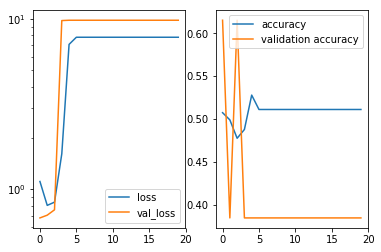


Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
1074/1074 [==============================] - 80s 75ms/step - loss: 7.7931 - acc: 0.5112 - val_loss: 9.8061 - val_acc: 0.3849


In [23]:
############################################
## define our Basic Model 1, without regularization techniques

def getModel_2_with_angle(with_compile=True,
               with_bn=False,
               with_dropout=False,
               optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)):
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, (3, 3),activation='relu', input_shape=(75, 75,3)))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Conv Layer 2
    gmodel.add(Conv2D(128, (3, 3), activation='relu' ))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Conv Layer 3
    gmodel.add(Conv2D(128, (3, 3), activation='relu'))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Conv Layer 4
    gmodel.add(Conv2D(64, (3, 3), activation='relu'))
    if with_bn:
        gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if with_dropout:
        gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    
    
    
    
    # Image input encoding
    image_input = Input(shape=(75,75,3))
    encoded_image = gmodel(image_input)

    # Inc angle input
    inc_angle_input = Input(shape=(1,))

    # Combine image and inc angle
    combined= keras.layers.concatenate([encoded_image,inc_angle_input])
    
    dense_model = Sequential()
    #Dense Layers
    dense_model.add(Dense(512, input_shape=(257,)))
    if with_bn:
        dense_model.add(BatchNormalization())
    dense_model.add(Activation('relu'))
    if with_dropout:
        dense_model.add(Dropout(0.2))
    
    #Dense Layer 2
    dense_model.add(Dense(256))
    if with_bn:
        dense_model.add(BatchNormalization())
    dense_model.add(Activation('relu'))
    if with_dropout:
        dense_model.add(Dropout(0.2))
    
    #Sigmoid Layer
    dense_model.add(Dense(1))
    dense_model.add(Activation('sigmoid'))

    
    output = dense_model(combined)

    # Final model
    combined_model= Model(inputs=[image_input,inc_angle_input],outputs= output)

    if with_compile:
        combined_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return combined_model


def to_tensor_multi_input(data, fn_process_band=None, fn_create_band_3=None):
    print("to_tensor_multi_input")
    print(data.shape)
    a = to_tensor(data, fn_process_band=fn_process_band, fn_create_band_3=fn_create_band_3)
    print(a.shape)
    b = data['inc_angle_corrected']
    print(b.shape)
    
    return [a,b]

m2_bn = MyModel("Model 2 - (HH+HV)/2 -  minmaxmean scaler Adam with bn",
             getModel_2_with_angle(with_dropout=True, optimizer=SGD(0.01)), 
             lambda data: to_tensor_multi_input(data, 
                                                fn_process_band=min_max_mean_scaler, 
                                                fn_create_band_3=create_band3_3),
             get_callback_1("models2/model2_band3_3_minmaxmean_opt_Adam_with_bn_weights.hdf5"))

m2_bn.model.summary()

m2_bn.train2(train_data,
            train_data['is_iceberg'],
            validation_split=0.33)

## Data Augmentation

In [ ]:
###########################################################
## Prepare models and datagen

m1_datagen_0 = MyModel("Model 1 - (HH/HV) - minmaxscaler",
             getModel_1(), 
             lambda data: to_tensor(data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_1),
             get_callback_1("model1_band3_1_min_max_scaler_weights_datagen.hdf5"))

from keras.preprocessing.image import ImageDataGenerator
datagen1 = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,
                             
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')

datagen2 = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,
                             
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')

train_generator = MyDataGenerator(datagen1, True, 
                                  save_to_dir="/Users/bicho/Documents/GitHub/udacity-capstone/data/generator/model1_band3_1_min_max_scaler_weights_datagen/train/")
                            



In [ ]:
###########################################################
## train withd datagen

m1_datagen_0.train(train_data, train_data['is_iceberg'], idx_train, idx_valid, 
        train_img_generator=train_generator)

In [ ]:
###########################################################
## a manual way

_to_process = False

if _to_process:
    for e in range(1):
        print('Epoch', e)
        batches = 0
        for batch in datagen_original.flow(X_train,
                 y_train,
                 batch_size=32, 
                 save_to_dir='/Users/bicho/Documents/GitHub/udacity-capstone/data/original',
                                      seed =  seed):
            break
            if batches > 0:
                break
            batches += 1

## Using Already existing CNN

### Transfer learning

In [ ]:
from keras.applications import vgg16
from keras.applications import resnet50
from keras.applications import vgg19
from keras.applications import inception_v3

apps = [vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(75,75,3))]


inn this kernel we will use pretrained VGG-16 network which performs very well on small size images.

5. VGG architecture has proved to worked well on small sized images(CIFAR-10) I expected it to work well for this dataset as well.

Keras provide the implementation of pretrained VGG, it in it's library so we don't have to build the net by ourselves. Here we are removing the last layer of VGG and putting our sigmoid layer for binary predictions.

In [ ]:
apps[0].output_shape
keras.__version__

In [ ]:
def getTopModel(base_model, with_compile=True):
    print(base_model.output_shape[1:])
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    if with_compile:
        top_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])
    return top_model


"""
train_data -> X_Train, X_Valid (pre_process)
generator(train_data), generator(valid_data)
fit base_model
save output

"""
def train_topmodel_with_inputof_basemodel(base_model ,
                                          idxs, 
                                          data, target,
                                          path_save_weights,
                                          train_gen=None, valid_gen=None, 
                                           fit_base=True,
                                         epochs=50):
    idx_train, idx_valid = idxs
    X_train, y_train= data[idx_train], target[idx_train] 
    X_valid, y_valid= data[idx_valid], target[idx_valid] 
    
    batch_size = 32
    if fit_base:
        print("Predicting base model for training...")
        if train_gen:
            train_gen.fit(X_train)
            train_generator = train_gen.flow(X_train,
                                     batch_size=batch_size)
            bottleneck_features_train = base_model.predict_generator(train_generator, X_train.shape[0]/batch_size)
        else:
            bottleneck_features_train = base_model.predict(X_train)
        np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

        print("Predicting base model for validating...")
        #bottleneck_features_validation = base_model.predict_generator(valid_generator,  X_valid.shape[0]/batch_size)
        if valid_gen:
            valid_gen.fit(X_valid)
            valid_generator = valid_gen.flow(X_valid,
                                     batch_size=batch_size)
            bottleneck_features_validation = base_model.predict_generator(valid_generator,  X_valid.shape[0]/batch_size)
        else:
            bottleneck_features_validation = base_model.predict(X_valid)
        np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
    
    
    ####
    print("Loading input for top model for training...")
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    # the features were saved in order, so recreating the labels is easy
    train_labels = y_train

    print("Loading input for top model for validating...")
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = y_valid

    print("Fitting Top model...")
    top_model = getTopModel(base_model)
    top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    print("Saving weights Top model...")
    top_model.save_weights(path_save_weights)
    return top_model

base_model = apps[0]
_datas = to_tensor(train_data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_1)
_target = train_data['is_iceberg']


train_gen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,                            
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')
valid_gen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,                            
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')



top_model = train_topmodel_with_inputof_basemodel(base_model,  
                                          (idx_train[:5], idx_valid[:5]), 
                                          _datas, _target,
                                          "weight_top_model.hf5",
                                           train_gen=None, valid_gen=None,  
                                           fit_base=True)




### Fine Tuning

In [ ]:
base_model.summary()

In [ ]:
len(base_model.layers)

In [ ]:

def train_topmodel_and_basemodel(base_model ,top_model_weights_path,
                                          idxs, 
                                          data, target,
                                          train_gen=None, valid_gen=None, 
                                           fit_base=True, epochs=50):
    batch_size = 32
    idx_train, idx_valid = idxs
    X_train, y_train= data[idx_train], target[idx_train] 
    X_valid, y_valid= data[idx_valid], target[idx_valid] 
    
    top_model = getTopModel(base_model)
    top_model.load_weights(top_model_weights_path)

    # CREATE AN "REAL" MODEL FROM VGG16
    # BY COPYING ALL THE LAYERS OF VGG16
    new_model = Sequential()
    for l in base_model.layers:
        new_model.add(l)
    
    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in new_model.layers[:15]:
        layer.trainable = False
        

    # CONCATENATE THE TWO MODELS
    new_model.add(top_model)

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    new_model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

    # fine-tune the model
    if train_gen and valid_gen:
        train_gen.fit(X_train)
        train_generator = train_gen.flow(X_train,
                                     batch_size=32)
        
        valid_gen.fit(X_valid)
        valid_generator = valid_gen.flow(X_valid,
                                     batch_size=32)
            
        hist = new_model.fit_generator(
            train_generator,
            samples_per_epoch=len(X_train),
            epochs=epochs,
            validation_data=valid_generator,
            nb_val_samples=len(X_valid))
    else:
        hist = new_model.fit(X_train, y_train,
                  batch_size=batch_size,
                  nb_epoch=epochs,
                  verbose=True,
                  validation_data=(X_valid, y_valid))
    return new_model

base_model = apps[0]
_datas = to_tensor(train_data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_1)
_target = train_data['is_iceberg']




train_gen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,                            
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')
valid_gen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,                            
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')



top_model = train_topmodel_and_basemodel(base_model,  "weight_top_model.hf5",
                                          (idx_train, idx_valid), 
                                          _datas, _target,
                                         train_gen=None, valid_gen=None)





In [ ]:
help(base_model)

# Improvement

- Use of Incident angle
- Batch normalization
- Use Data augmentation
- Use spekkle filtering

# Submission

In [ ]:
def predict(data, gmodel, preprocess):
    X_test = preprocess(data)
    return gmodel.predict_proba(X_test)

def create_csv(path, predicted_test):
    result = pd.DataFrame()
    result['id']=test_data['id']
    result['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
    result.to_csv(path, index=False)

In [ ]:
test_data[:10]

In [ ]:
X_test = to_tensor(test_data, fn_process_band=no_process, fn_create_band_3=create_band3_2)


In [ ]:
X_test.shape

In [ ]:
predicted_test = m1_0_b.model.predict_proba(X_test)

In [ ]:
predicted_test.shape

In [ ]:
create_csv('res.csv', predicted_test)